# **[Project] Cancer Subtype Classification**

# Introduction

The [TCGA Kidney Cancers Dataset](https://archive.ics.uci.edu/dataset/892/tcga+kidney+cancers) is a bulk RNA-seq dataset that contains transcriptome profiles (i.e., gene expression quantification data) of patients diagnosed with three different subtypes of kidney cancers.
This dataset can be used to make predictions about the specific subtype of kidney cancers given the normalized transcriptome profile data.

The normalized transcriptome profile data is given as **TPM** and **FPKM** for each gene.

> TPM (Transcripts Per Million) and FPKM (Fragments Per Kilobase Million) are two common methods for quantifying gene expression in RNA sequencing data.
> They both aim to account for the differences in sequencing depth and transcript length when estimating gene expression levels.
>
> **TPM** (Transcripts Per Million):
> - TPM is a measure of gene expression that normalizes for both library size (sequencing depth) and transcript length.
> - The main idea behind TPM is to express the abundance of a transcript relative to the total number of transcripts in a sample, scaled to one million.
>
> **FPKM** (Fragments Per Kilobase Million):
> - FPKM is another method for quantifying gene expression, which is commonly used in older RNA-seq analysis pipelines. It's similar in concept to TPM but differs in the way it's calculated.
> - FPKM also normalizes for library size and transcript length, but it measures gene expression as the number of fragments (i.e., reads) per kilobase of exon model per million reads.
>
> TPM is generally considered more robust to variations in library size, making it a preferred choice in many modern RNA-seq analysis workflows.

We provide one dataset for each kidney cancer subtype:

- [TCGA-KICH](https://portal.gdc.cancer.gov/projects/TCGA-KICH): kidney chromophobe (renal clear cell carcinoma)
- [TCGA-KIRC](https://portal.gdc.cancer.gov/projects/TCGA-KIRC): kidney renal clear cell carcinoma
- [TCGA-KIRP](https://portal.gdc.cancer.gov/projects/TCGA-KIRP): kidney renal papillary cell carcinoma

> This and _much_ more data is openly available on the [NCI Genomic Data Commons (GDC) Data Portal](https://portal.gdc.cancer.gov/).

# Data access

There are two ways to access the data: via the TNT homepage or the GDC Data Portal.

## Download from the TNT homepage (_recommended_)

The download from the TNT homepage is straightforward:

In [ ]:
# ! wget http://www.tnt.uni-hannover.de/edu/vorlesungen/AMLG/data/project-cancer-classification.tar.gz
# ! tar -xzvf project-cancer-classification.tar.gz
# ! mv -v project-cancer-classification/ data/
# ! rm -v project-cancer-classification.tar.gz

In the `data/` folder you will now find many files in the [TSV format](https://en.wikipedia.org/wiki/Tab-separated_values) ([CSV](https://en.wikipedia.org/wiki/Comma-separated_values)-like with tabs as delimiter) containing the normalized transcriptome profile data.

To start, you can read a TSV file into a [pandas](https://pandas.pydata.org) [`DataFrame`](pandas dataframe to dict) using the [`pandas.read_csv()`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html#pandas-read-csv) function with the `sep` parameter set to `\t`:

## ML Pipeline (Data Preprocessing, Data Visualization, Feature Selection, Algorithm Selection, Hyperparameter Optimization)

Our ML pipeline includes the following necessary steps:
1. Data Preprocessing & Visualization: Understand the data & Preprocess it in a useful format
2. Feature Selection: Select the most important features
3. Algorithm Selection: Select the ML algorithm
4. Hyperparameter Optimization: Optimize the hyperparameter of the ML algorithm

## Data Preprocessing & Visualization

Before we applying some ML algorithms, we have to preprocess our data into numerical/categorical values so that the ML algorithms can handle these values.

Each sample contains the following multiple rows:
 - **gene_id:** Id of the specific gene
 - **gene_name:** Name of the specific gene
 - **gene_type:** Type of the specific gene
 - **unstranded:** Unstranded expression values for the corresponding gene
 - **stranded_first:** Expression values for the first (sense) strand of the gene
 - **stranded_second:** Expression values for the second (antisense) strand of the gene
 - **tpm_unstranded:** Transcripts per Million
 - **fpkm_unstranded:** Fragments per Kilobase of transcript per Million mapped reads
 - **fpkm_uq_unstranded:** Upper quartile fragments per Kilobase of transcripts per Million mapped reads
 - **class_index:** The label of the corresponding subtype of kidney cancer and columns

The following example shows how each sample is constructed:

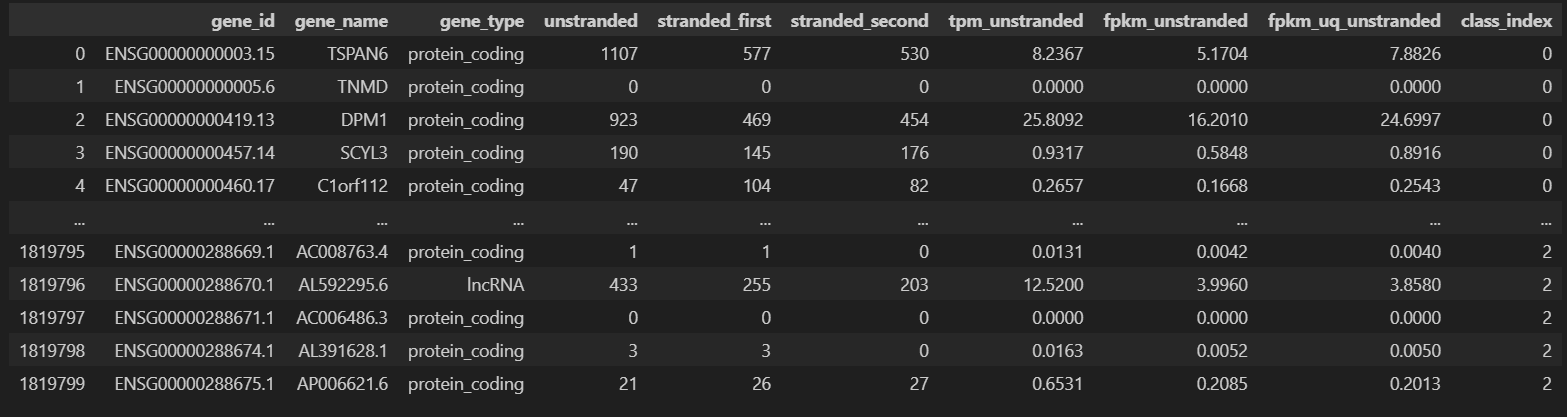

In [64]:
from typing import Optional
import numpy as np

def iqm(x: np.ndarray, axis: Optional[int] = None) -> np.ndarray:
    """
    Compute the interquartile mean (IQM) along the specified axis.

    Args:
        x (np.ndarray): 
            Numpy array of shape (?, ?)
        
        axis (int, optional): 
            Axis or axes along which the interquartile mean (IQM) is computed
    
    Returns:
        np.ndarray:
            Interquartile mean (IQM) along the specified axis
    """
    if axis is None:
        axis = 0
    
    # Calculate the 0.25 quantile (first quartile) and 0.75 quantile (third quantile)
    first_quartile = np.quantile(x, 0.25, axis=axis)
    third_quartile = np.quantile(x, 0.75, axis=axis)
    
    # Set the values of outliers to NaN
    filtered_x = x.copy().astype(float)
    mask = np.apply_along_axis(lambda arr: (arr < first_quartile) | (arr > third_quartile), axis=axis-1, arr=filtered_x)
    filtered_x[mask] = np.nan
    
    return np.nanmean(filtered_x, axis=axis)

def iqstd(x: np.ndarray, axis: Optional[int] = None) -> np.ndarray:
    """
    Compute the interquartile standard deviation (IQ std) along the specified axis.

    Args:
        x (np.ndarray): 
            Numpy array of shape (?, ?)
        
        axis (int, optional): 
            Axis or axes along which the interquartile standard deviation (IQ std) is computed
    
    Returns:
        np.ndarray:
            Interquartile standard deviation (IQ std) along the specified axis
    """
    if axis is None:
        axis = 0
    
    # Calculate the 0.25 quantile (first quartile) and 0.75 quantile (third quantile)
    first_quartile = np.quantile(x, 0.25, axis=axis)
    third_quartile = np.quantile(x, 0.75, axis=axis)
    
    # Set the values of outliers to NaN
    filtered_x = x.copy().astype(float)
    mask = np.apply_along_axis(lambda arr: (arr < first_quartile) | (arr > third_quartile), axis=axis-1, arr=filtered_x)
    filtered_x[mask] = np.nan
    
    return np.nanstd(filtered_x, axis=axis)

In [80]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import glob
import os

def load_profile_data(file_path: str, remove_header: bool = True) -> pd.DataFrame:
    """
    Loads a specific RNA-sequence data (one sample).

    Args:
        file_path (str):
            Specific path of the file

        remove_header (bool, optional):
            Controls if the header (first four rows of df) should be removed

    Returns:
        pd.DataFrame:
            RNA-sequence data of one sample
    """
    
    # Read the TSV file into a DataFrame
    df = pd.read_csv(filepath_or_buffer=file_path, sep="\t")
    
    # Remove Multi-Key Index and make it tabular
    df.reset_index(inplace=True)

    # Rename the new columns level_i into the corresponding columns
    df.rename(columns={
        "level_0": "gene_id",
        "level_1": "gene_name",
        "level_2": "gene_type",
        "level_3": "unstranded",
        "level_4": "stranded_first",
        "level_5": "stranded_second",
        "level_6": "tpm_unstranded",
        "level_7": "fpkm_unstranded",
        "# gene-model: GENCODE v36": "fpkm_uq_unstranded",
    }, inplace=True)

    # Remove the first row
    df = df.iloc[1:]
    
    # Change the dtypes of specific columns
    df["unstranded"] = df["unstranded"].astype(int)
    df["stranded_first"] = df["stranded_first"].astype(int)
    df["stranded_second"] = df["stranded_second"].astype(int)
    df["tpm_unstranded"] = df["tpm_unstranded"].astype(float)
    df["fpkm_unstranded"] = df["fpkm_unstranded"].astype(float)
    df["fpkm_uq_unstranded"] = df["fpkm_uq_unstranded"].astype(float)
    
    if remove_header:
        # Case: Remove the header rows
        df = df.iloc[4:]
    return df

def preprocess_dataset(
    df: pd.DataFrame,
    continuous_columns: list[str] = ["tpm_unstranded", "fpkm_unstranded", "fpkm_uq_unstranded"],
    categorical_columns: list[str] = ["gene_id", "gene_name", "gene_type"],
    label_encoding: bool = True,
    normalize: bool = True,
    remove_duplicates: bool = True,
    remove_nans: bool = True,
    remove_outliers: bool = True,
) -> pd.DataFrame:
    """
    Preprocess the dataset by (...)
        - Optional: Removing duplicates
        - Optional: Removing rows where at least one column contains NaN value
        - Optional: Removing outliers from continuous columns that are not within the +/- 2.0 of the IQR (interquartile range)
        - Optional: Encode categorical columns to numerical with label encoding
        - Optional: Normalize continuous columns with mean := 0.0 and std := 1.0

    Args:
        df (pd.DataFrame):
            Dataframe where we want to preprocess
        
        continuous_columns (list[str], optional):
            The columns of the dataframe which corresponds to continuous values
        
        categorical_columns (list[str], optional):
            The columns of the dataframe which corresponds to categorical values
        
        label_encoding (bool, optional):
            Controls if label-encoding should be used for categorical features (:= True)
        
        normalize (bool, optional):
            Controls if the data should be normalized with mean := 0.0, std := 1.0 (:= True)
        
        remove_duplicates (bool, optional):
            Controls if duplicate rows should be removed (:= True)
        
        remove_nans (bool, optional):
            Controls if rows that contain NaNs columns should be removed (:= True)
        
        remove_outliers (bool, optional): 
            Controls if outliers should be removed (:= True)

    Returns:
        pd.DataFrame:
            Preprocessed DataFrame
    """
    
    # Remove duplicates
    if remove_duplicates:
        df.drop_duplicates(inplace=True)

    # Remove NaNs
    if remove_nans:
        df.dropna(inplace=True)

    # Remove Outliers from (stay with the 50% of the dataset 25% lowest and 25% highest)
    if remove_outliers:
        # Calculate the interquartile range (IQR)
        Q1 = df[continuous_columns].quantile(0.25)
        Q3 = df[continuous_columns].quantile(0.75)
        IQR = Q3 - Q1

        # Define the lower and upper bounds to filter outliers
        lower_bound = Q1 - 2.0 * IQR
        upper_bound = Q3 + 2.0 * IQR
        
        for column in continuous_columns:
            mask = (df[column] >= lower_bound[column]) & (df[column] <= upper_bound[column])
            df = df[mask]
    
    # Apply One-hot encoding for categorical features
    if label_encoding:
        encoder = LabelEncoder()
        for column in categorical_columns:
            labels = encoder.fit_transform(df[column])
            df[column] = labels
    
    # Apply standard normalization (mean := 0.0, std := 1.0)
    if normalize:
        if label_encoding:
            columns = continuous_columns + categorical_columns
        else:
            columns = continuous_columns
        scaler = StandardScaler()
        df[columns] = scaler.fit_transform(df[columns])
    return df

def load_cancer_classification_dataset(
    data_path: str, 
    remove_header: bool = True,
    n_samples: Optional[int] = None,
) -> pd.DataFrame:
    """
    Loads the entire cancer classification dataset.

    Args:
        data_path (str):
            Specific path of the dataset
        
        remove_header (bool, optional):
            Controls if the header (first four rows of df) should be removed for each instance
        
        n_samples (int, optional): 
            Number of instances for each class

    Returns:
        pd.DataFrame:
            Cancer classification dataset
    """
    datasets = ["tcga-kich-geq", "tcga-kirc-geq", "tcga-kirp-geq"]
    tsv_files = []
    dfs = []
    ys = []
    root_dir = os.path.join(os.getcwd(), data_path)

    # Get the paths of all tsv files
    for i, dataset in enumerate(datasets):
        dataset_path = os.path.join(root_dir, dataset)
        paths = glob.glob(os.path.join(dataset_path, "*/*.tsv"))
        
        if n_samples:
            tsv_files += paths[:n_samples]
            ys += [i] * len(paths[:n_samples])
        else:
            tsv_files += paths
            ys += [i] * len(paths)

    # Load the data from all tsv files
    for i, tsv_file in enumerate(tsv_files):
        df = load_profile_data(tsv_file, remove_header)
        df["class_index"] = [ys[i]] * len(df)  # Add class index to each row
        df["class_index"] = df["class_index"].astype(int)
        dfs += [df]
    
    # Concatenate each df together to a dataset
    dataset = pd.concat(dfs, ignore_index=True)
    return dataset

In [81]:
def calculate_gene_statistics(
    df: pd.DataFrame,
    by: list[str],
    columns: list[str],
    agg_funcs: list[str] = ["sum", "min", "max", "mean", "median", "std", iqm, iqstd],
):  
    """
    Group by the given dataframe by each gene and class index and creates for each group the given statistics 
    (sum, min, max, mean, median, iqm, std and iqstd).

    Args:
        df (pd.DataFrame):
            DataFrame, where we want to aggregate the given columns
        
        by (list[str]):
            Columns we want to group
        
        columns (list[str]):
            Columns we want to aggregate
        
        agg_funcs (list[str], optional):
            List of aggregation functions (statistics) we want to compute

    Returns:
        pd.DataFrame:
            Aggregated DataFrame with the given statistics
    """
    statistics = df[by + columns].groupby(by).agg(agg_funcs)
    statistics.columns = ["_".join(col).strip() for col in statistics.columns.values]
    flatten_statistics = statistics.reset_index()
    return flatten_statistics

In [70]:
# Load one sample (tsv file) of the dataset
df = load_profile_data("data/tcga-kich-geq/00ddf8c2-039f-409f-a2ed-b29e18395dd4/f07b7c4c-5f30-4c51-9eb1-4f873ad49c56.rna_seq.augmented_star_gene_counts.tsv")
df

,gene_id,gene_name,gene_type,unstranded,stranded_first,stranded_second,tpm_unstranded,fpkm_unstranded,fpkm_uq_unstranded
5,ENSG00000000003.15,TSPAN6,protein_coding,1107,577,530,8.2367,5.1704,7.8826
6,ENSG00000000005.6,TNMD,protein_coding,0,0,0,0.0000,0.0000,0.0000
7,ENSG00000000419.13,DPM1,protein_coding,923,469,454,25.8092,16.2010,24.6997
8,ENSG00000000457.14,SCYL3,protein_coding,190,145,176,0.9317,0.5848,0.8916
9,ENSG00000000460.17,C1orf112,protein_coding,47,104,82,0.2657,0.1668,0.2543
...,...,...,...,...,...,...,...,...,...
60660,ENSG00000288669.1,AC008763.4,protein_coding,0,0,0,0.0000,0.0000,0.0000
60661,ENSG00000288670.1,AL592295.6,lncRNA,195,83,126,3.6421,2.2863,3.4856
60662,ENSG00000288671.1,AC006486.3,protein_coding,0,0,0,0.0000,0.0000,0.0000
60663,ENSG00000288674.1,AL391628.1,protein_coding,1,0,1,0.0035,0.0022,0.0034


In [82]:
# Load 100 samples (tsv files) from each class and concatenates them into a dataset (~ 3 min.)
df = load_cancer_classification_dataset("data", remove_header=True, n_samples=100)
df

,gene_id,gene_name,gene_type,unstranded,stranded_first,stranded_second,tpm_unstranded,fpkm_unstranded,fpkm_uq_unstranded,class_index
0,ENSG00000000003.15,TSPAN6,protein_coding,1107,577,530,8.2367,5.1704,7.8826,0
1,ENSG00000000005.6,TNMD,protein_coding,0,0,0,0.0000,0.0000,0.0000,0
2,ENSG00000000419.13,DPM1,protein_coding,923,469,454,25.8092,16.2010,24.6997,0
3,ENSG00000000457.14,SCYL3,protein_coding,190,145,176,0.9317,0.5848,0.8916,0
4,ENSG00000000460.17,C1orf112,protein_coding,47,104,82,0.2657,0.1668,0.2543,0
...,...,...,...,...,...,...,...,...,...,...
17652055,ENSG00000288669.1,AC008763.4,protein_coding,0,0,0,0.0000,0.0000,0.0000,2
17652056,ENSG00000288670.1,AL592295.6,lncRNA,199,112,104,6.8440,2.6822,3.6606,2
17652057,ENSG00000288671.1,AC006486.3,protein_coding,0,0,0,0.0000,0.0000,0.0000,2
17652058,ENSG00000288674.1,AL391628.1,protein_coding,0,0,0,0.0000,0.0000,0.0000,2


In [83]:
# Remove duplicates, NaNs and outliers from the dataset
df = preprocess_dataset(
    df,
    continuous_columns=["tpm_unstranded", "fpkm_unstranded", "fpkm_uq_unstranded"],
    categorical_columns=["gene_name", "gene_type"],
    label_encoding=False,
    normalize=False,
    remove_duplicates=True,
    remove_nans=True,
    remove_outliers=True,
)
df

,gene_id,gene_name,gene_type,unstranded,stranded_first,stranded_second,tpm_unstranded,fpkm_unstranded,fpkm_uq_unstranded,class_index
0,ENSG00000000003.15,TSPAN6,protein_coding,1107,577,530,8.2367,5.1704,7.8826,0
1,ENSG00000000005.6,TNMD,protein_coding,0,0,0,0.0000,0.0000,0.0000,0
3,ENSG00000000457.14,SCYL3,protein_coding,190,145,176,0.9317,0.5848,0.8916,0
4,ENSG00000000460.17,C1orf112,protein_coding,47,104,82,0.2657,0.1668,0.2543,0
5,ENSG00000000938.13,FGR,protein_coding,296,147,150,2.9539,1.8542,2.8269,0
...,...,...,...,...,...,...,...,...,...,...
17652047,ENSG00000288658.1,AC010980.1,protein_coding,1,3,8,0.0209,0.0082,0.0112,2
17652049,ENSG00000288660.1,AC004233.4,protein_coding,2,1,1,0.1710,0.0670,0.0914,2
17652052,ENSG00000288663.1,AC073611.1,lncRNA,5,3,2,0.0545,0.0214,0.0292,2
17652056,ENSG00000288670.1,AL592295.6,lncRNA,199,112,104,6.8440,2.6822,3.6606,2


In [84]:
# Groups each gene for each class label together and computes statistic values (mean, median, std)
df = calculate_gene_statistics(
    df,
    by=["gene_id", "class_index", "gene_name", "gene_type"],
    columns=["unstranded", "stranded_first", "stranded_second", "tpm_unstranded", "fpkm_unstranded", "fpkm_uq_unstranded"],
    agg_funcs=["mean", "median", "std"],
)
df

,gene_id,class_index,gene_name,gene_type,unstranded_mean,unstranded_median,unstranded_std,stranded_first_mean,stranded_first_median,stranded_first_std,...,stranded_second_std,tpm_unstranded_mean,tpm_unstranded_median,tpm_unstranded_std,fpkm_unstranded_mean,fpkm_unstranded_median,fpkm_unstranded_std,fpkm_uq_unstranded_mean,fpkm_uq_unstranded_median,fpkm_uq_unstranded_std
0,ENSG00000000003.15,0,TSPAN6,protein_coding,1473.461538,1471.0,508.308114,744.730769,762.5,259.989470,...,249.290356,12.149304,12.63970,4.456848,5.665350,5.15040,1.579630,7.505023,7.11020,1.878708
1,ENSG00000000003.15,1,TSPAN6,protein_coding,1516.714286,1403.0,575.457066,734.785714,686.5,346.652382,...,270.888526,16.416971,15.67080,5.174499,6.683807,6.77995,1.176893,7.952550,7.69810,1.138961
2,ENSG00000000003.15,2,TSPAN6,protein_coding,1511.000000,1511.0,380.423448,769.500000,769.5,218.495995,...,161.927453,15.471450,15.47145,0.335098,6.875150,6.87515,0.387282,8.857250,8.85725,1.421355
3,ENSG00000000005.6,0,TNMD,protein_coding,51.058140,16.0,85.860126,25.872093,9.0,43.572467,...,42.562568,1.658228,0.43920,2.962113,0.575821,0.17420,0.955780,0.628624,0.23765,1.019934
4,ENSG00000000005.6,1,TNMD,protein_coding,62.489362,20.0,135.797900,31.893617,10.5,69.297468,...,66.619497,2.121480,0.80795,4.007251,0.713701,0.26975,1.309072,0.764110,0.28410,1.372233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178366,ENSG00000288674.1,1,AL391628.1,protein_coding,6.690722,6.0,4.662262,3.402062,3.0,2.928523,...,2.516441,0.037558,0.03520,0.024292,0.012713,0.01080,0.008722,0.014137,0.01200,0.011357
178367,ENSG00000288674.1,2,AL391628.1,protein_coding,4.702128,4.0,3.512894,2.468085,2.0,2.113460,...,1.936772,0.027469,0.01870,0.021133,0.010356,0.00715,0.008562,0.011668,0.00780,0.010469
178368,ENSG00000288675.1,0,AP006621.6,protein_coding,13.571429,10.0,13.966741,17.120879,14.0,11.982242,...,13.247637,0.366334,0.25150,0.527446,0.140834,0.09290,0.178101,0.169005,0.11160,0.217302
178369,ENSG00000288675.1,1,AP006621.6,protein_coding,16.870000,13.0,14.547488,17.570000,15.0,12.787506,...,10.965861,0.543707,0.46280,0.420491,0.188834,0.14725,0.165757,0.212223,0.15725,0.206760


In [107]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def plot_scatter_matrix(
    X: np.ndarray,
    y: np.ndarray,
    labels: list[str],
    columns: list[str],
    colors: list[str] = ["blue", "red", "yellow"],
    figsize: tuple[int, int] = (10, 10),
    bins: int = 30,
    alpha: float = 0.3
):
    """
    Plots the scatter matrix across the given different features X.

    Args:
        X (np.ndarray):
            The feature vector of shape (N, ?)
        
        y (np.ndarray):
            The true class labels of shape (N,)
        
        labels (list[str]):
            The label of each class index
        
        columns (list[str]):
            The label of each feature
        
        colors (list[str], optional):
            The colors between the different class index
        
        figsize (tuple[int, int], optional):
            Size of the figure
        
        bins (int, optional):
            Number of bins for the histogram
        
        alpha (float, optional):
            Transparency level
    """
    assert X.shape[1] == len(columns), "The number of columns should be equal to the number of columns of the feature matrix X!"
    
    # Remove nan and inf from dataset
    mask = np.any(np.isnan(X) | np.isinf(X), axis=1)
    X = X[~mask]
    y = y[~mask]
    
    y_unique = np.unique(y)

    # Create a scatter matrix plot
    fig, ax = plt.subplots(X.shape[1], X.shape[1], figsize=figsize)
    for i in range(X.shape[1]):
        for j in range(X.shape[1]):
            
            if X.shape[1] == 1:
                cur_ax = ax
            else:
                cur_ax = ax[i][j]
                
            if j == 0:
                cur_ax.set_ylabel(columns[i])

            if i == X.shape[1] - 1:
                cur_ax.set_xlabel(columns[j])

            if i == j:
                for y_ in y_unique:
                    cur_ax.hist(X[y == y_, i], bins=bins, label=labels[y_], color=colors[y_], alpha=alpha)
            else:
                for y_ in y_unique:
                    cur_ax.scatter(X[y == y_, j], X[y == y_, i], label=labels[y_], color=colors[y_], alpha=alpha)
            cur_ax.legend(loc="upper right")
    plt.show()

def plot_boxplot(
    X: np.ndarray,
    y: np.ndarray,
    labels: list[str],
    columns: list[str],
    figsize: tuple[int, int] = (20, 20),
):
    """
    Plots the boxplots across the given different features X.

    Args:
        X (np.ndarray):
            The feature vector of shape (N, ?)
        
        y (np.ndarray):
            The true class labels of shape (N,)
        
        labels (list[str]):
            The label of each class index
        
        columns (list[str]):
            The label of each feature
        
        figsize (tuple[int, int], optional):
            Size of the figure
    """
    assert X.shape[1] == len(columns), "The number of columns should be equal to the number of columns of the feature matrix X!"

    # Remove nan and inf from dataset
    mask = np.any(np.isnan(X) | np.isinf(X), axis=1)
    X = X[~mask]
    y = y[~mask]
    
    y_unique = np.unique(y)
    
    fig, ax = plt.subplots(X.shape[1], figsize=figsize)
    for i in range(X.shape[1]):
        if X.shape[1] == 1:
            cur_ax = ax
        else:
            cur_ax = ax[i]
        
        cur_ax.set_ylabel(columns[i])
        
        splits = [X[y == y_, i] for y_ in y_unique]
        cur_ax.boxplot(splits, labels=labels, vert=True, patch_artist=True)
    plt.show()

def plot_cumulative_variance_ratio(X: np.ndarray, y: np.ndarray, figsize: tuple[int, int] = (20, 20)):
    """
    Plots the cumulative variance ratio from the PCA component, to decide how many components do we choose.

    Args:
         X (np.ndarray):
            The feature vector of shape (N, ?)
        
        y (np.ndarray):
            The true class labels of shape (N,)
            
        figsize (tuple[int, int], optional):
            Size of the figure
    """
    
    # Remove nan and inf from dataset
    mask = np.any(np.isnan(X) | np.isinf(X), axis=1)
    X = X[~mask]
    y = y[~mask]
    
    # Initialize the PCA
    pca = PCA(n_components=X.shape[1])

    # Transform the data
    pca.fit(X)

    # Plot the cumulative variance ratio to how many components should be used
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    
    plt.subplots(figsize=figsize)
    plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio)
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.show()

In [108]:
# Select which features should be used
# columns = ["tpm_unstranded_sum", "tpm_unstranded_min", "tpm_unstranded_max", "tpm_unstranded_mean", "tpm_unstranded_median", "tpm_unstranded_std", "fpkm_unstranded_sum", "fpkm_unstranded_min", "fpkm_unstranded_max", "fpkm_unstranded_mean", "fpkm_unstranded_median", "fpkm_unstranded_std", "fpkm_uq_unstranded_sum", "fpkm_uq_unstranded_min", "fpkm_uq_unstranded_max", "fpkm_uq_unstranded_mean", "fpkm_uq_unstranded_median", "fpkm_uq_unstranded_std", "unstranded_sum", "unstranded_min", "unstranded_max", "unstranded_mean", "unstranded_median", "unstranded_std", "stranded_first_sum", "stranded_first_min", "stranded_first_max", "stranded_first_mean", "stranded_first_median", "stranded_first_std", "stranded_second_sum", "stranded_second_min", "stranded_second_max", "stranded_second_mean", "stranded_second_median", "stranded_second_std"]
# columns = ["tpm_unstranded_mean", "tpm_unstranded_median", "tpm_unstranded_std", "fpkm_unstranded_mean", "fpkm_unstranded_median", "fpkm_unstranded_std", "fpkm_uq_unstranded_mean", "fpkm_uq_unstranded_median", "fpkm_uq_unstranded_std", "unstranded_mean", "unstranded_median", "unstranded_std", "stranded_first_mean", "stranded_first_median", "stranded_first_std", "stranded_second_mean", "stranded_second_median", "stranded_second_std"]
columns = ["tpm_unstranded_mean", "tpm_unstranded_median", "tpm_unstranded_std"]
# columns = ["gene_name", "gene_type", "tpm_unstranded", "fpkm_unstranded", "fpkm_uq_unstranded"]

# Name of the different class labels
labels = ["tcga-kich-geq", "tcga-kirc-geq", "tcga-kirp-geq"]

# Define X (feature matrix) and y (true outputs)
X = df[columns].to_numpy()
y = df["class_index"].to_numpy()

In [44]:
# Plot the scatter matrix plot
plot_scatter_matrix(X, y, labels, columns, figsize=(100, 100))

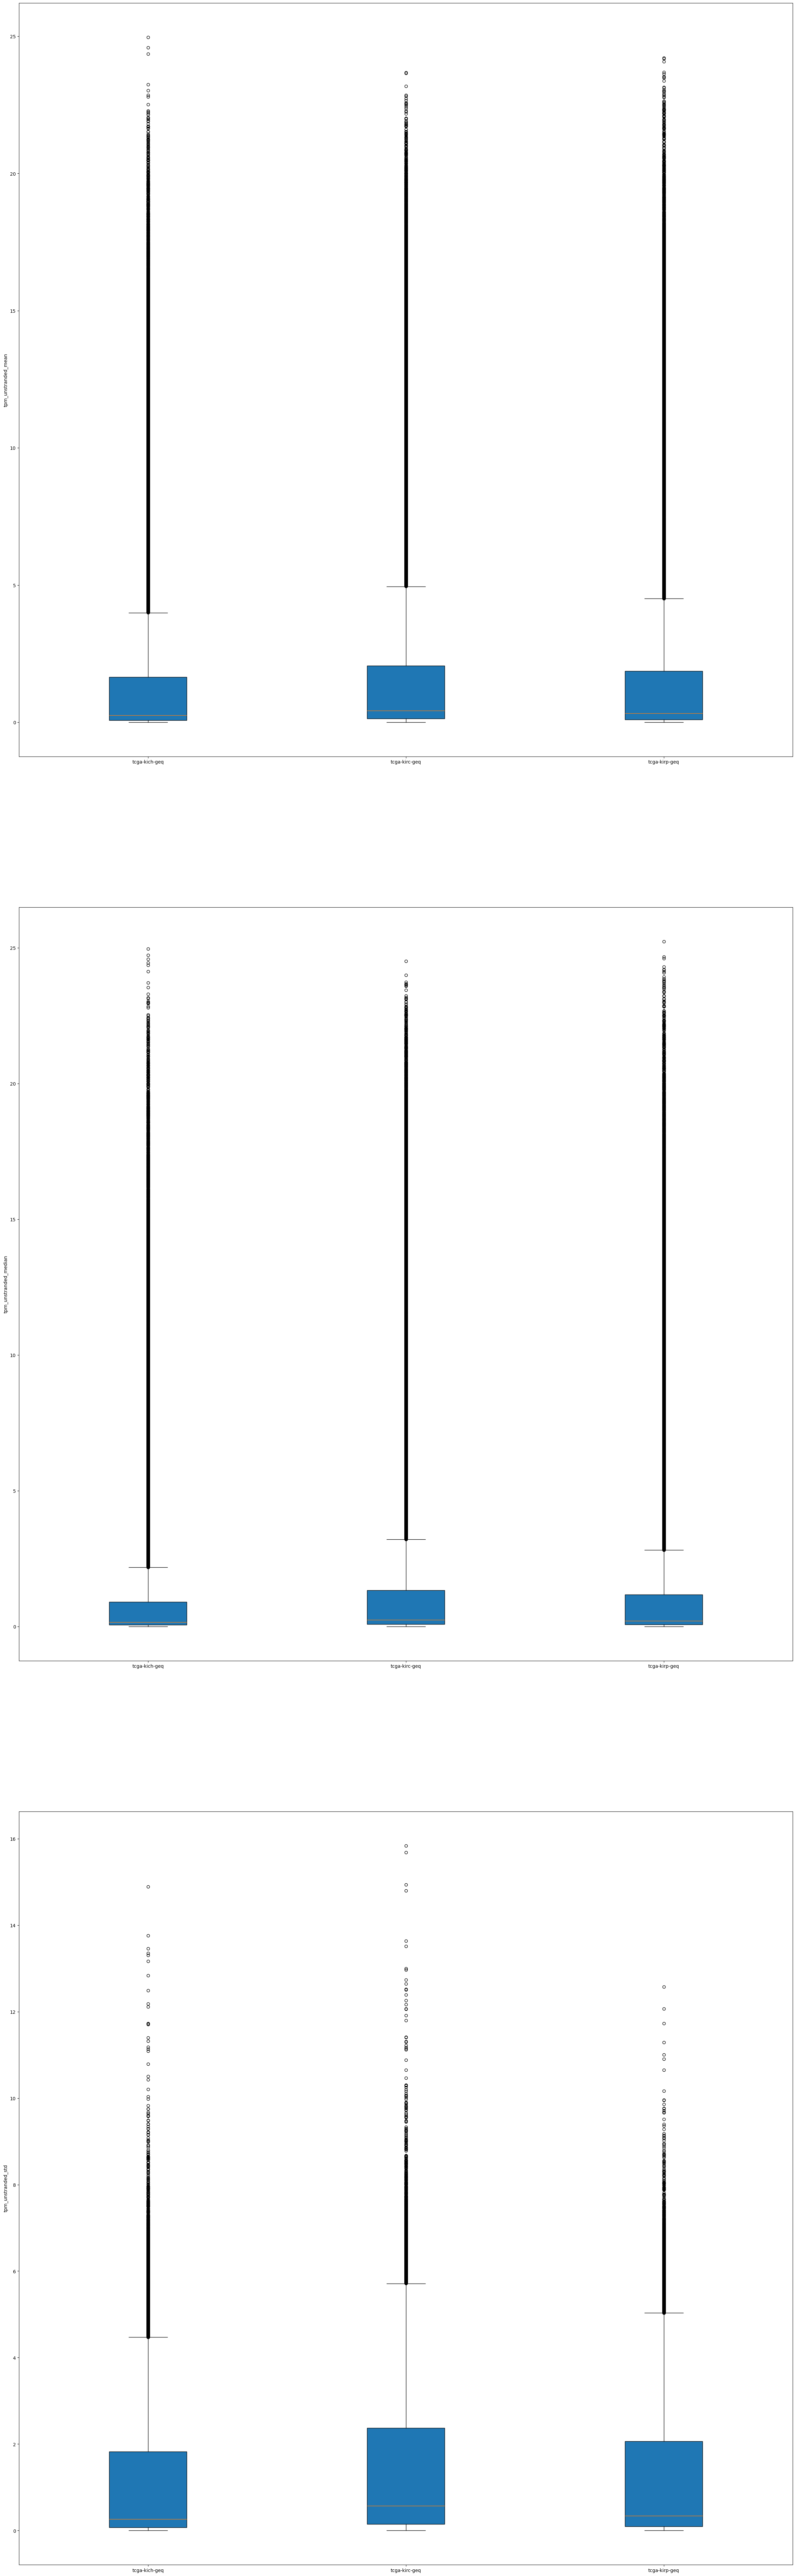

In [109]:
# Plot the boxplot for each feature between different classes
plot_boxplot(X, y, labels, columns, figsize=(30, 100))

## Feature Reduction
Now lets start to reduce the features by using PCA.

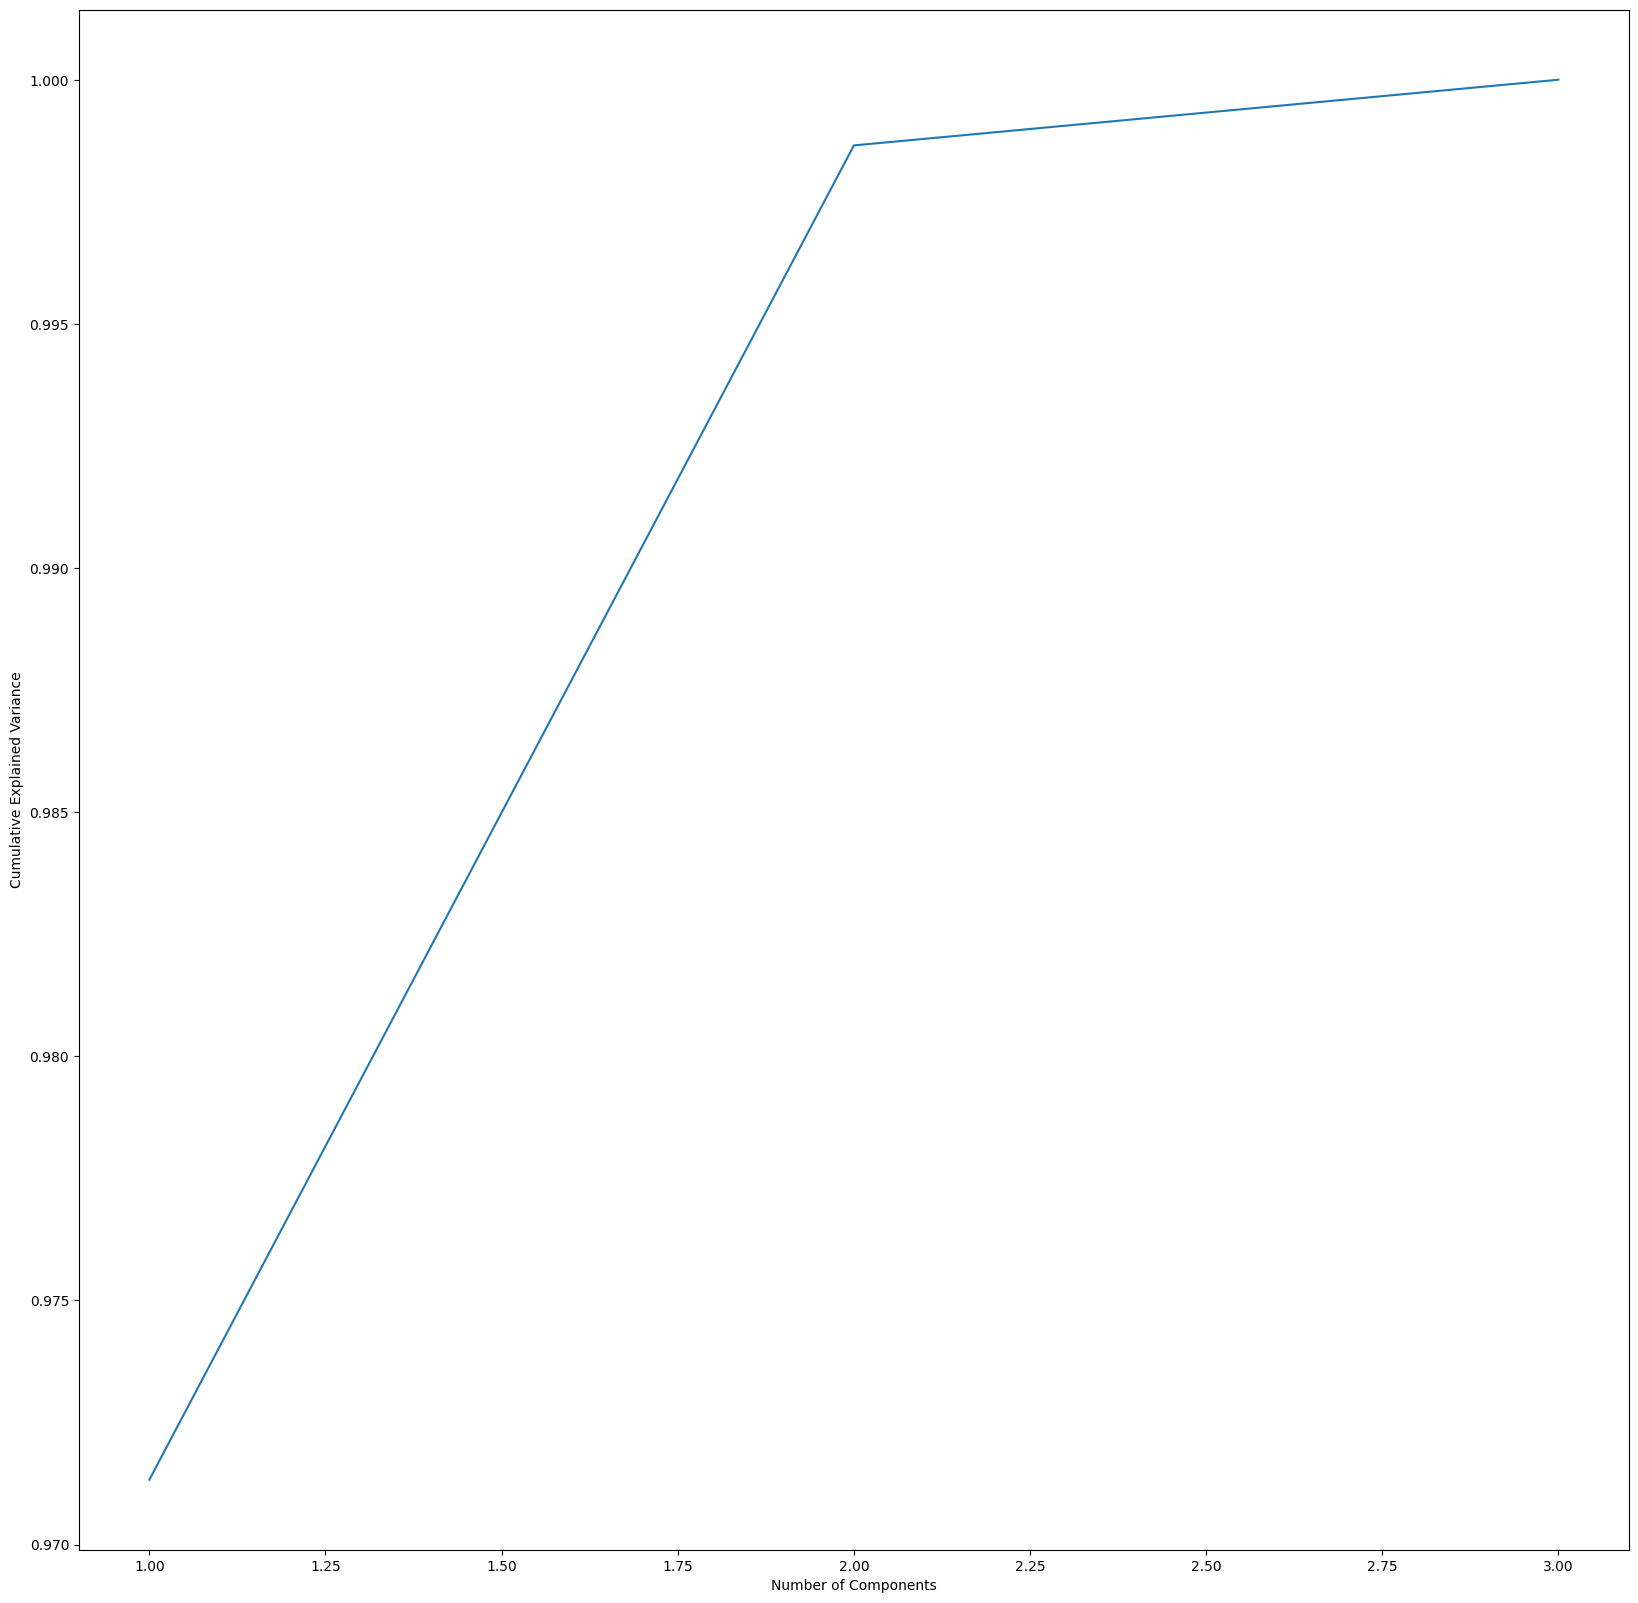

In [110]:
# Plot the cumulative variance ratio from PCA
plot_cumulative_variance_ratio(X, y, figsize=(20, 20))

In [111]:
# Initialize the PCA
pca = PCA(n_components=1)

# Remove nan and inf from dataset
mask = np.any(np.isnan(X) | np.isinf(X), axis=1)
X = X[~mask]
y = y[~mask]

# Transform the data
X = pca.fit_transform(X)

## Algorithm Selection & Training

First lets start with a Random Forest Classifier and see if it can classify the kidney cancer subtypes correctly.

In [128]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator
from ConfigSpace import Configuration, ConfigurationSpace
from typing import Type

def eval_model(
    model: BaseEstimator,
    X: np.ndarray,
    y: np.ndarray,
    n_splits: int = 3, 
    random_state: int = 0
) -> float:
    """
    Evaluates a given Classifier, by K-Fold cross validation (CV).

    Args:
        model (BaseEstimator): 
            The classifier we want to evaluate
            
        X (np.ndarray):
            The feature vector of shape (N, ?)
            
        y (np.ndarray):
            The output class labels of shape (N, ?)
        
        n_splits (int, optional): 
            Number of splits for K-Fold cross validation
        
        random_state (int, optional):
            Random Seed for reproducibility

    Returns:
        float:
            Mean over the k-computed (balanced) accuracy scores
    """
    scores = []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    for train_idx, val_idx in kf.split(X):
        
        # Get the train/test dataset
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Evaluate the model
        y_pred = model.predict(X_val)
        score = balanced_accuracy_score(y_true=y_val, y_pred=y_pred)
        scores += [score]
    return np.mean(scores)

def eval_configuration(
    model_cls: Type[BaseEstimator],
    cfg: Configuration,
    X: np.ndarray,
    y: np.ndarray,
    n_splits: int = 3,
    random_state: int = 1,
) -> float:  
    """
    Evaluates a configuration (:= set of hyperparameters) to a given model class, by K-Fold cross validation (CV).

    Args:
        model_cls (Type[BaseEstimator]):
            The model class (:= classifier) we want to use
            
        cfg (Configuration):
            The configuration we want to evaluate
        
        X (np.ndarray):
            The feature vector of shape (N, ?)

        y (np.ndarray):
            The output class labels of shape (N, ?)
        
        n_splits (int, optional): 
            Number of splits for K-Fold cross validation
        
        random_state (int, optional):
            Random Seed for reproducibility

    Returns:
        float:
            Mean over the k-computed (balanced) accuracy scores
    """
    model = model_cls(**cfg, random_state=random_state)
    return eval_model(model, X, y, n_splits=n_splits, random_state=random_state)

def random_search(cs: ConfigurationSpace, X: np.ndarray, y: np.ndarray, n_cfgs: int = 50) -> Configuration:
    """
    Performs Random Search for finding best hyperparameter configuration.

    Args:
        cs (ConfigurationSpace):
            The configuration space from where we sample
        
        X (np.ndarray):
            The feature vector of shape (N, ?)
        
        y (np.ndarray):
            The output class labels of shape (N, ?)
        
        n_cfgs (int, optional):
            The number of configuration we want to evaluate/sample
    
    Returns:
        Configuration:
            The best configuration across the sampled configurations
    """
    assert n_cfgs >= 1, f"Illegal n_cfgs {n_cfgs}. The argument should be higher or equal to 1!"
    
    if n_cfgs == 1:
        cfgs = [cs.sample_configuration()]
    else:
        cfgs = cs.sample_configuration(n_cfgs)
    scores = []
    model_cls = cs.meta["model_class"]
    n_splits = cs.meta["n_splits"]
    random_state = cs.meta["random_state"]
    for cfg in cfgs:
        score = eval_configuration(model_cls, cfg, X, y, n_splits, random_state)
        scores += [score]
    return cfgs[np.argmax(scores)]

In [114]:
from ConfigSpace import Integer, Categorical

# Initialize the Configuration Space
random_state = 0
cs = ConfigurationSpace(
    seed=random_state,
    space={
        "n_estimators": Integer("n_estimators", bounds=(10, 30), default=20),
        "criterion": Categorical("criterion", items=["gini", "entropy", "log_loss"], default="gini"),
        "max_depth": Integer("max_depth", bounds=(1, 20), default=10),
        "min_samples_split": Integer("min_samples_split", bounds=(2, 10), default=2),
        "min_samples_leaf": Integer("min_samples_leaf", bounds=(1, 10), default=1),
        "max_features": Categorical("max_features", items=["sqrt", "log2"], default="sqrt"),
    },
    meta={
        "model_class": RandomForestClassifier,
        "n_splits": 3,
        "random_state": random_state,
    }
)

In [115]:
# Split the data into train test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [116]:
# Do Random Search
# best_cfg = random_search(cs, X_train, y_train, n_cfgs=20)
best_cfg = random_search(cs, X_train, y_train, n_cfgs=1)
best_cfg

Configuration(values={
  'criterion': 'entropy',
  'max_depth': 15,
  'max_features': 'log2',
  'min_samples_leaf': 6,
  'min_samples_split': 5,
  'n_estimators': 23,
})

In [117]:
# Initialize the model
model = RandomForestClassifier(**best_cfg, random_state=random_state)

# Train the model
model.fit(X_train, y_train)

# Get the accuracy of the model
y_pred = model.predict(X_test)

In [118]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

# Print the balanced accuracy, f1_score and roc_auc_score
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
balanced_accuracy = balanced_accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")

print(f"Accuracy Score: {accuracy}")
print(f"Balanced Accuracy Score: {balanced_accuracy}")
print(f"F1 Score: {f1}")

Accuracy Score: 0.3797449180526523
Balanced Accuracy Score: 0.37817305252770766
F1 Score: 0.373143011782594


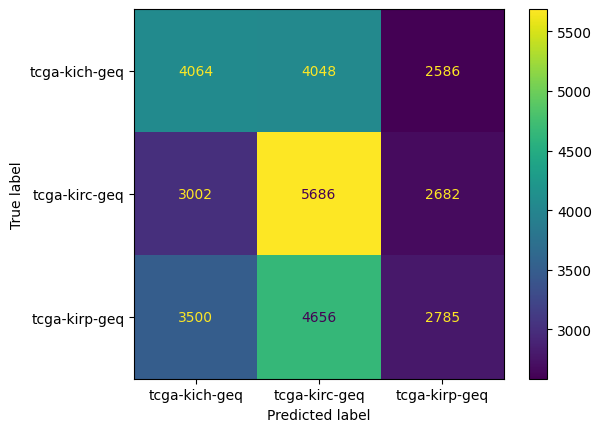

In [119]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_pred, display_labels=labels)

Lets try out to use a Neural Network model instead of using Random Forest.

In [120]:
from torch.utils.data import DataLoader, TensorDataset
from typing import Union
import torch.nn as nn
import torch

class MLP(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        n_hidden_layers: int,
        act_fn_type: str,
        loss_fn_type: str,
        optimizer_fn_type: str,
        lr: float,
        batch_size: int,
        n_epochs: int,
        random_state: int,
    ):
        # Sets the random state for pytorch / numpy
        torch.manual_seed(random_state)
        np.random.seed(random_state)
        
        super().__init__()
        layers = []  # list of all modules (including activation functions)
        act_fn_cls = self.get_act_fn(act_fn_type)  # class of activation function to use
        loss_fn_cls = self.get_loss_fn(loss_fn_type)  # class of loss function to use
        optimizer_fn_cls = self.get_optimizer_fn(optimizer_fn_type)  # class of optimizer to use

        if n_hidden_layers >= 1:
            # Case: There exist at least one hidden layer
            layer = nn.Linear(input_dim, hidden_dim)
            act_func = act_fn_cls()
            layers += [layer, act_func]
        
        for _ in range(n_hidden_layers - 1):
            # Case: Insert the other n-1 hidden layer
            layer = nn.Linear(hidden_dim, hidden_dim)
            act_func = act_fn_cls()
            layers += [layer, act_func]
        
        if n_hidden_layers >= 1:
            # Case: At least one hidden layer was used
            layers += [nn.Linear(hidden_dim, output_dim)]
        else:
            # Case: Not hidden layers are used
            layers += [nn.Linear(input_dim, output_dim)]
        
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.model = nn.Sequential(*layers)
        self.loss_fn = loss_fn_cls()
        self.optimizer = optimizer_fn_cls(params=self.model.parameters(), lr=lr)
    
    def forward(self, X: Union[np.ndarray, torch.Tensor]) -> torch.Tensor:
        """
        The forward pass of the MLP model.

        Args:
            X (Union[np.ndarray, torch.Tensor]):
                The feature matrix (X)
        
        Returns:
            torch.Tensor:
                The predicted probability distribution for each class (y_logits)
        """
        if isinstance(X, np.ndarray):
            X_ = torch.from_numpy(X).to(dtype=torch.float32)
        else:
            X_ = X
        return self.model.forward(X_)
    
    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Trains the MLP model for a given number of epochs.

        Args:
            X (np.ndarray):
                Feature matrix for training (X_train)
            
            y (np.ndarray):
                Labels vector for training (y_train)
        """
        self.model.train()

        # Create DataLoader for (mini-)batch training
        X_train = torch.from_numpy(X).to(dtype=torch.float32)
        y_train = torch.from_numpy(y).to(dtype=torch.int64)
        dataset = TensorDataset(X_train, y_train)
        dataloader = DataLoader(dataset=dataset, batch_size=self.batch_size, shuffle=True)

        for i in range(self.n_epochs):
            running_loss = 0.0
            n = 0
            for _, (inputs, targets) in enumerate(dataloader):
                # Zero your gradients for every batch
                self.optimizer.zero_grad()
                
                # Make predictions for this batch
                outputs = self.model.forward(inputs)
                
                # Compute the loss and its gradients
                loss = self.loss_fn(outputs, targets)
                loss.backward()
                
                # Adjust learning weights
                self.optimizer.step()
                
                # Update running loss and number of batches
                running_loss += loss.item()
                n += 1
            
            # Compute loss of i-th epoch
            epoch_loss = running_loss / n
            print(f"Epoch {i+1}: {epoch_loss}")
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predicts the class labels, given new data points.

        Args:
            X (np.ndarray):
                The feature matrix of new unseen data points (X_test)

        Returns:
            np.ndarray:
                The predicted class labels (y_pred)
        """
        self.model.eval()
        
        # Get the probability distribution over each class
        y_pred = self.forward(X)
        
        # Convert logits to probability distribution
        y_pred = y_pred.softmax(dim=1)
        
        # Select the class with the highest probability
        y_pred = y_pred.argmax(dim=1)
        
        # Convert to numpy array
        y_pred = y_pred.detach().cpu().numpy()
        
        return y_pred
    
    def get_act_fn(self, act_fn_type: str) -> Type[nn.Module]:
        """
        Returns the activation function (for each layer), given the type.

        Args:
            act_fn_type (str):
                The type of the activation function

        Returns:
            Type[nn.Module]:
                The class of the activation function
        """
        act_fns = {
            "relu": nn.ReLU,
            "sigmoid": nn.Sigmoid,
            "tanh": nn.Tanh,
        }
        if act_fn_type not in act_fns:
            raise ValueError(f"Unknown act_fn_type {act_fn_type}!")
        else:
            return act_fns[act_fn_type]
    
    def get_loss_fn(self, loss_fn_type: str) -> Type[nn.Module]:
        """
        Returns the loss function class, given the type.

        Args:
            loss_fn_type (str):
                Type of the loss function as string

        Returns:
            Type[nn.Module]:
                The class of the Loss function
        """
        loss_fns = {
            "ce": nn.CrossEntropyLoss,
        }
        if loss_fn_type not in loss_fn_type:
            raise ValueError(f"Unknown loss_fn_type {loss_fn_type}!")
        return loss_fns[loss_fn_type]

    def get_optimizer_fn(self, optimizer_fn_type: str) -> Type[torch.optim.Optimizer]:
        """
        Returns the optimizer class, given the type.

        Args:
            optimizer_fn_type (str):
                Type of the optimizer class as string

        Returns:
            Type[torch.optim.Optimizer]:
                The class of the optimizer
        """
        optimizer_fns = {
            "adam": torch.optim.Adam,
            "adamw": torch.optim.AdamW,
            "sgd": torch.optim.SGD,
            "rmsprop": torch.optim.RMSprop,
        }
        if optimizer_fn_type not in optimizer_fns:
            raise ValueError(f"Unknown optimizer_fn_type {optimizer_fn_type}!")
        return optimizer_fns[optimizer_fn_type]

In [129]:
from ConfigSpace import Float, Constant

# Initialize the Configuration Space
cs = ConfigurationSpace(
    seed=random_state,
    space={
        "input_dim": Constant("input_dim", value=X.shape[1]),
        "hidden_dim": Integer("hidden_dim", bounds=(16, 64), default=32),
        "output_dim": Constant("output_dim", value=3),
        "n_hidden_layers": Integer("n_hidden_layers", bounds=(0, 10), default=3),
        "act_fn_type": Categorical("act_fn_type", items=["relu", "sigmoid", "tanh"], default="relu"),
        "loss_fn_type": Constant("loss_fn_type", value="ce"),
        "optimizer_fn_type": Categorical("optimizer_fn_type", items=["adam", "adamw"], default="adam"), # "sgd", "rmsprop"], default="adam"),
        "lr": Float("lr", bounds=(1e-5, 1e-2), default=1e-3),
        "batch_size": Integer("batch_size", bounds=(16, 64), default=32),
        "n_epochs": Constant("n_epochs", value=10),
    },
    meta={
        "model_class": MLP,
        "n_splits": 3,
        "random_state": random_state,
    }
)

In [130]:
# Do Random Search
# best_cfg = random_search(cs, X_train, y_train, n_cfgs=20)
best_cfg = random_search(cs, X_train, y_train, n_cfgs=1)
best_cfg

Epoch 1: 1.0991912627827942
Epoch 2: 1.097393301381435
Epoch 3: 1.0976744790756827
Epoch 4: 1.0970854567210617
Epoch 5: 1.096621166029783
Epoch 6: 1.0933216263908085
Epoch 7: 1.0924550664383457
Epoch 8: 1.0919457987589742
Epoch 9: 1.0919333594837166
Epoch 10: 1.0920924533283725
Epoch 1: 1.091526132469796
Epoch 2: 1.091958767983756
Epoch 3: 1.0918478311696722
Epoch 4: 1.0914415545839284
Epoch 5: 1.0918380777639696
Epoch 6: 1.0915766133908462
Epoch 7: 1.0916399649783606
Epoch 8: 1.0918304813143
Epoch 9: 1.0920401904839905
Epoch 10: 1.091807348357982
Epoch 1: 1.0924211190031412
Epoch 2: 1.0922712943368826
Epoch 3: 1.0927086089881244
Epoch 4: 1.0924996416648873
Epoch 5: 1.0928505368332184
Epoch 6: 1.0927407660047812
Epoch 7: 1.0926596764065024
Epoch 8: 1.092641047779406
Epoch 9: 1.0925223666436426
Epoch 10: 1.0926451211318218


Configuration(values={
  'act_fn_type': 'sigmoid',
  'batch_size': 51,
  'hidden_dim': 45,
  'input_dim': 1,
  'loss_fn_type': 'ce',
  'lr': 0.005453382998139,
  'n_epochs': 10,
  'n_hidden_layers': 4,
  'optimizer_fn_type': 'adamw',
  'output_dim': 3,
})

In [131]:
# Initialize the model
model = MLP(**best_cfg, random_state=random_state)

# Train the model
model.fit(X_train, y_train)

# Get the accuracy of the model
y_pred = model.predict(X_test)

Epoch 1: 1.0974352256171536
Epoch 2: 1.0933162862612686
Epoch 3: 1.0928498614290223
Epoch 4: 1.0928576942022448
Epoch 5: 1.0929041974744358
Epoch 6: 1.09275380319129
Epoch 7: 1.0930038410616272
Epoch 8: 1.0925823690901395
Epoch 9: 1.093102260462885
Epoch 10: 1.0929234192701969


In [132]:
# Print the balanced accuracy, f1_score and roc_auc_score
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
balanced_accuracy = balanced_accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")

print(f"Accuracy Score: {accuracy}")
print(f"Balanced Accuracy Score: {balanced_accuracy}")
print(f"F1 Score: {f1}")

Accuracy Score: 0.3733527219849132
Balanced Accuracy Score: 0.37384180694930363
F1 Score: 0.368440689386223


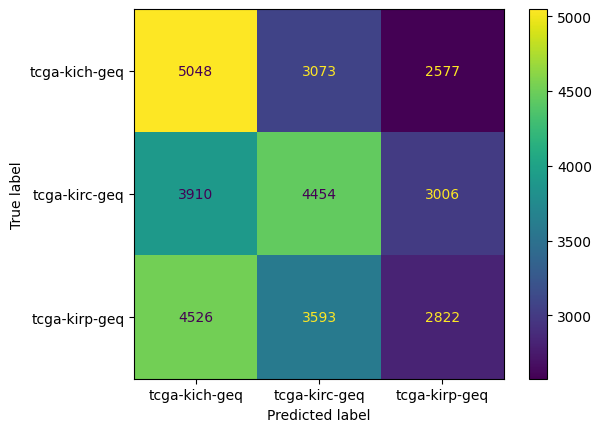

In [133]:
# Plot the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_pred, display_labels=labels)